In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial import cKDTree
from scipy.stats import mode

import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from datasets import DatasetDIDC

%load_ext autoreload
%autoreload 2

In [2]:
# load file npz

DATA_PATH = './New_dictionary'

## Shape analysis

In [3]:
shapes = []
for file in os.listdir(DATA_PATH):
    if file.endswith('.npy'):
        pat = np.load(DATA_PATH + '/' + file, allow_pickle=True).item()
        shapes.append([pat['interpolated_intensity'].shape, 
                       pat['interpolated_segmentation'].shape,
                       pat['mask_foreground'].shape])
shape_vect = np.array(shapes)

In [4]:
category_names = list(pat.keys())[:3]

for cat in range(shape_vect.shape[1]):
    print(f'Analysis of category {category_names[cat]}:')
    shape_val = shape_vect[:, cat, :]

    unique, counts = np.unique(shape_val, axis=0, return_counts=True)
    for u, c in zip(unique, counts):
        print(f'Shape {u}, {c}')
    print('\n')



Analysis of category interpolated_intensity:
Shape [384 384  20], 418
Shape [384 384  21], 8
Shape [384 384  22], 55
Shape [384 384  24], 3
Shape [432 432  20], 1
Shape [480 480  20], 1
Shape [560 560  20], 1


Analysis of category interpolated_segmentation:
Shape [384 384  20], 418
Shape [384 384  21], 8
Shape [384 384  22], 55
Shape [384 384  24], 3
Shape [432 432  20], 1
Shape [480 480  20], 1
Shape [560 560  20], 1


Analysis of category mask_foreground:
Shape [384 384  20], 418
Shape [384 384  21], 8
Shape [384 384  22], 55
Shape [384 384  24], 3
Shape [432 432  20], 1
Shape [480 480  20], 1
Shape [560 560  20], 1




In [5]:
shape_vect[0]

array([[384, 384,  20],
       [384, 384,  20],
       [384, 384,  20]])

In [6]:
pat.keys()

dict_keys(['interpolated_intensity', 'interpolated_segmentation', 'mask_foreground', 'affine_cine', 'resolution_cine', 'dimensions'])

(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

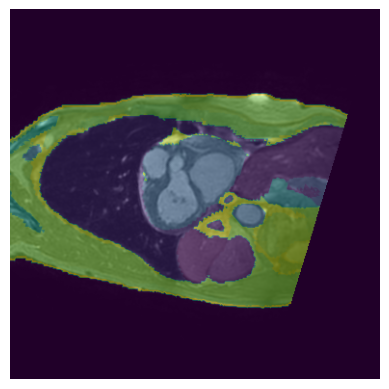

In [7]:
plt.imshow(pat['interpolated_intensity'][:,:,10], cmap='gray')
plt.imshow(pat['interpolated_segmentation'][:,:,10], cmap='viridis', alpha=0.5)
plt.axis('off')

## Label Analysis

In [8]:
original_labels = []

with open (DATA_PATH + '/tissue_list.txt', 'r') as f:

    for i, line in enumerate(f):
        if i > 1:
            line = line.strip().split()[-1]
            original_labels.append(line)
        
print(original_labels)
original_labels_bkg = ['background'] + original_labels
print(original_labels_bkg)

['Spleen', 'Kidney_right', 'Kidney_left', 'Gallbladder_bile', 'Liver', 'Stomach_lumen', 'Pancreas', 'Adrenal_gland_right', 'Adrenal_gland_left', 'Lung', '__unused__', '__unused__', '__unused__', '__unused__', 'Esophagus_lumen', 'Trachea_lumen', 'Thyroid_gland', 'Intestine_lumen', 'Small_intestine_duodenum', '__unused__', '__unused__', '__unused__', '__unused__', 'Heart', 'Aorta', 'Vein_pulmonary', 'Artery_brachiocephalic', 'Artery_subclavian_right', 'Artery_subclavian_left', 'Artery_common_carotid_right', 'Artery_common_carotid_left', 'Vein_brachiocephalic_left', 'Vein_brachiocephalic_right', 'Atrial_appendage_left', 'Vena_cava_superior', 'Vena_cava_inferior', 'Vein_portal_and_splenic', '__unused__', '__unused__', '__unused__', '__unused__', 'Humerus_left', '__unused__', 'Scapula_left', 'Scapula_right', 'Clavicle_left', 'Clavicle_right', '__unused__', '__unused__', '__unused__', 'Pelvis_right', 'Spinal_cord', '__unused__', '__unused__', '__unused__', '__unused__', '__unused__', '__unus

In [9]:
# load a generic patient 
pat_files = sorted(os.listdir(DATA_PATH))
pat_idx_false = np.random.randint(0, len(pat_files))

pat = np.load(DATA_PATH + '/' + pat_files[pat_idx_false], allow_pickle=True).item()


In [10]:
print('Pat ID:', pat_files[pat_idx_false].split('-')[1])

Pat ID: 284


In [11]:
pat_idx_false

274

Slice number: 12


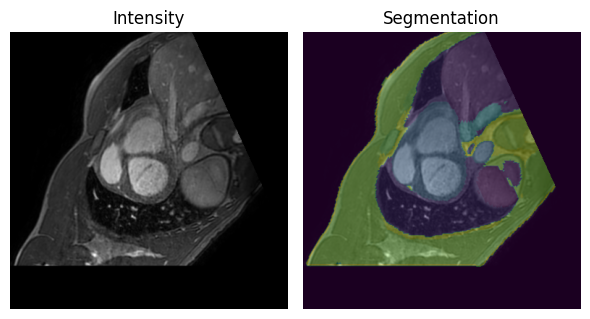

In [12]:
slice_idx = np.random.randint(0, pat['interpolated_intensity'].shape[2])

ex_slice = pat['interpolated_intensity'][:,:,slice_idx]
ex_segmentation = np.round(pat['interpolated_segmentation'][:,:,slice_idx])
print(f'Slice number: {slice_idx}')

fig, ax = plt.subplots(1, 2, figsize=(6, 6))

ax[0].imshow(ex_slice, cmap='gray')
ax[0].set_title('Intensity')
ax[0].axis('off')
ax[1].imshow(ex_slice, cmap='gray')
ax[1].imshow(ex_segmentation, cmap='viridis', alpha=0.4)
ax[1].set_title('Segmentation')
ax[1].axis('off')
plt.tight_layout()


[0.00000000e+00 1.20398021e-06 1.76151623e-06 ... 2.82474724e+03
 2.84066256e+03 2.88009302e+03]


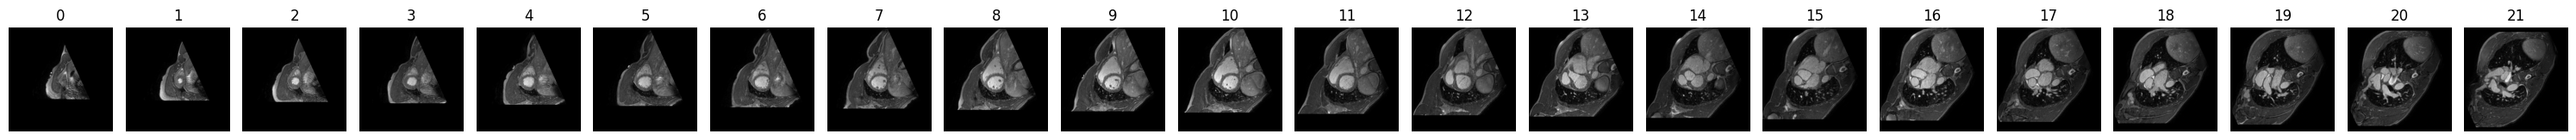

In [13]:
slices_black = pat['interpolated_intensity']
fig, ax = plt.subplots(1, slices_black.shape[2], figsize=(30, 30))
for i in range(slices_black.shape[2]):
    ax[i].imshow(slices_black[:,:,i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'{i}')
plt.tight_layout()

print(np.unique(slices_black))

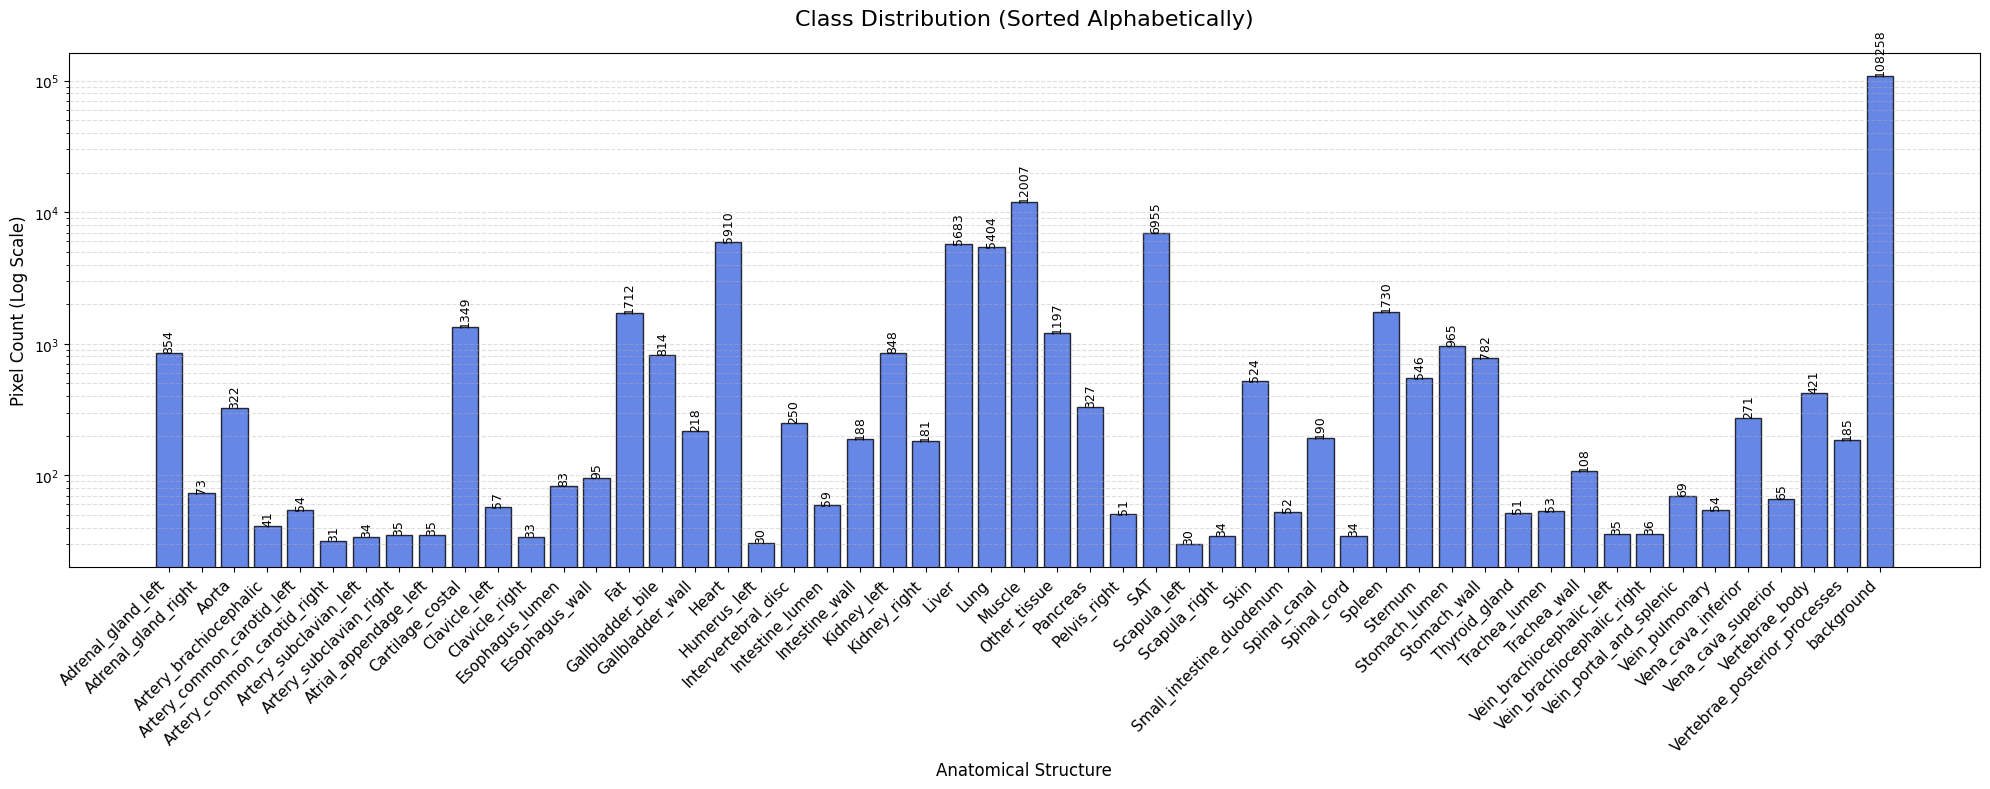

In [14]:
ex_segmentation_mean = pat['interpolated_segmentation'][:,:,2:13]
no_unk_labels = ["" if x == '__unused__' else x for x in original_labels_bkg]
# no_unk_labels = original_labels_bkg
counts = np.bincount(ex_segmentation_mean.flatten().astype(int))/10
indices = np.arange(len(counts))

if len(no_unk_labels) < len(counts):
    diff = len(counts) - len(no_unk_labels)
    no_unk_labels.extend(["Unknown"] * diff)
elif len(no_unk_labels) > len(counts):
    no_unk_labels = no_unk_labels[:len(counts)]

mask = (counts > 0) & (np.array(no_unk_labels) != "")
filtered_labels = [no_unk_labels[i] for i in indices if mask[i]]
filtered_counts = counts[mask]

# Sort both lists alphabetically by label name
sorted_data = sorted(zip(filtered_labels, filtered_counts))
filtered_labels, filtered_counts = zip(*sorted_data)

plt.figure(figsize=(20, 8))

bars = plt.bar(range(len(filtered_labels)), filtered_counts, 
               color='royalblue', edgecolor='black', alpha=0.8)

plt.xticks(range(len(filtered_labels)), filtered_labels, 
           rotation=45, ha='right', fontsize=11)

plt.title('Class Distribution (Sorted Alphabetically)', fontsize=16, pad=20)
plt.xlabel('Anatomical Structure', fontsize=12)
plt.ylabel('Pixel Count (Log Scale)', fontsize=12)
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.4, which='both')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}', 
             va='bottom', ha='center', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()

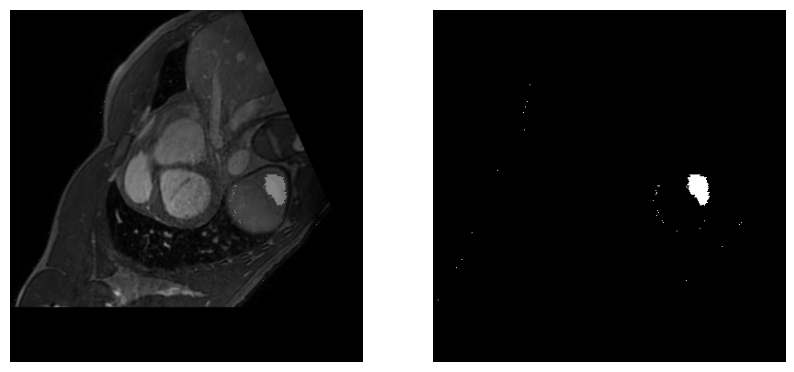

In [15]:
ex_segmentation_single_organ = ex_segmentation == original_labels_bkg.index('Kidney_left')

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(ex_slice, cmap='gray')
ax[0].imshow(ex_segmentation_single_organ, cmap='gray', alpha=0.3)
ax[1].imshow(ex_segmentation_single_organ, cmap='gray')
for a in ax:
    a.axis('off')

In [16]:
original_labels_bkg.index('Kidney_left')

3

In [17]:
np.unique(ex_segmentation)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80.])

In [18]:
print(ex_segmentation.dtype, np.max(ex_segmentation),np.min(ex_segmentation))

float64 80.0 0.0


### Check images all blacks

In [19]:
def check_black_slices(image):
    is_black = False
    cnt = 0
    black_slices = []
    for i in range(image.shape[2]):
        if np.all(image[:,:,i] == 0):
            black_slices.append(i)
            is_black = True
            cnt += 1
    return cnt, is_black, black_slices

In [20]:
# for file in sorted(os.listdir(DATA_PATH)):
#     if file.endswith('.npy'):
#         pat = np.load(DATA_PATH + '/' + file, allow_pickle=True).item()
#         cnt, is_black, black_slices = check_black_slices(pat['interpolated_intensity'])
#         if is_black:
#             pat_id = file.split('-')[1]
#             print(f'Patient {pat_id} has {cnt} black slices at indices {black_slices}')
# shape_vect = np.array(shapes)

### Remap labels
I want to remap the original labels in the interpolated segmentations into a new set of fewer grouped labels

In [21]:
original_labels_bkg = ['Background'] + original_labels
original_labels_bkg

['Background',
 'Spleen',
 'Kidney_right',
 'Kidney_left',
 'Gallbladder_bile',
 'Liver',
 'Stomach_lumen',
 'Pancreas',
 'Adrenal_gland_right',
 'Adrenal_gland_left',
 'Lung',
 '__unused__',
 '__unused__',
 '__unused__',
 '__unused__',
 'Esophagus_lumen',
 'Trachea_lumen',
 'Thyroid_gland',
 'Intestine_lumen',
 'Small_intestine_duodenum',
 '__unused__',
 '__unused__',
 '__unused__',
 '__unused__',
 'Heart',
 'Aorta',
 'Vein_pulmonary',
 'Artery_brachiocephalic',
 'Artery_subclavian_right',
 'Artery_subclavian_left',
 'Artery_common_carotid_right',
 'Artery_common_carotid_left',
 'Vein_brachiocephalic_left',
 'Vein_brachiocephalic_right',
 'Atrial_appendage_left',
 'Vena_cava_superior',
 'Vena_cava_inferior',
 'Vein_portal_and_splenic',
 '__unused__',
 '__unused__',
 '__unused__',
 '__unused__',
 'Humerus_left',
 '__unused__',
 'Scapula_left',
 'Scapula_right',
 'Clavicle_left',
 'Clavicle_right',
 '__unused__',
 '__unused__',
 '__unused__',
 'Pelvis_right',
 'Spinal_cord',
 '__unused_

In [22]:
grouping_rules = {
    "Background": "Background",
    "__unused__": "Others",
    "Other_tissue": "Others",
    "Cartilage_costal": "Bones_and_cartilage",
    "Humerus_left": "Bones_and_cartilage",
    "Scapula_left": "Bones_and_cartilage",
    "Scapula_right": "Bones_and_cartilage",
    "Clavicle_left": "Bones_and_cartilage",
    "Clavicle_right": "Bones_and_cartilage",
    "Pelvis_right": "Bones_and_cartilage",
    "Sternum": "Bones_and_cartilage",
    "Cartilage_costal": "Bones_and_cartilage",
    "Intervertebral_disc": "Bones_and_cartilage",
    "Vertebrae_body": "Bones_and_cartilage",
    "Vertebrae_posterior_processes": "Bones_and_cartilage",
    "Spinal_canal": "Bones_and_cartilage",
    "Kidney_right": "Kidneys",
    "Kidney_left":  "Kidneys",
    "Adrenal_gland_right": "Kidneys",
    "Adrenal_gland_left": "Kidneys",
    "Lung": "Lungs",
    "Vein_pulmonary": "Blood_vessels",
    "Artery_brachiocephalic": "Blood_vessels",
    "Artery_subclavian_right": "Blood_vessels",
    "Artery_subclavian_left": "Blood_vessels",
    "Artery_common_carotid_right": "Blood_vessels",
    "Artery_common_carotid_left": "Blood_vessels",
    "Vein_brachiocephalic_left": "Blood_vessels",
    "Vein_brachiocephalic_right": "Blood_vessels",
    "Vena_cava_superior": "Blood_vessels",
    "Vena_cava_inferior": "Blood_vessels",
    "Vein_portal_and_splenic": "Blood_vessels",
    "Stomach_wall": "Stomach",
    "Stomach_lumen": "Stomach",
    "Esophagus_lumen": "Esophagus_and_trachea",
    "Esophagus_wall": "Esophagus_and_trachea",
    "Trachea_wall": "Esophagus_and_trachea",
    "Trachea_lumen": "Esophagus_and_trachea",
    "Thyroid_gland": "Esophagus_and_trachea",
    "Intestine_lumen": "Intestine",
    "Small_intestine_duodenum": "Intestine",
    "Intestine_wall": "Intestine",
    "Gallbladder_wall": "Gallbladder",
    "Gallbladder_bile": "Gallbladder",
    "Fat": "Fat",
    "SAT": "Fat",
    "Muscle": "Muscle",
    "Skin": "Skin",
    "Spleen": "Spleen",
    "Pancreas": "Pancreas",
    "Heart": "Heart_generic",
    "Atrial_appendage_left": "Heart_generic",
    "Liver": "Liver",
    "Aorta": "Aorta",
    "Spleen": "Spleen",
    "Spinal_cord": "Spinal_cord",
}

new_labels = set()
for value in grouping_rules.values():
    new_labels.add(value)

foreground_labels = ["LV_Myocardium", "LV_blood_pool", "RV_blood_pool_myocardium"]
new_labels = new_labels.union(set(foreground_labels))

new_labels = sorted(list(new_labels))
print(new_labels, '\n', len(new_labels))

['Aorta', 'Background', 'Blood_vessels', 'Bones_and_cartilage', 'Esophagus_and_trachea', 'Fat', 'Gallbladder', 'Heart_generic', 'Intestine', 'Kidneys', 'LV_Myocardium', 'LV_blood_pool', 'Liver', 'Lungs', 'Muscle', 'Others', 'Pancreas', 'RV_blood_pool_myocardium', 'Skin', 'Spinal_cord', 'Spleen', 'Stomach'] 
 22


(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

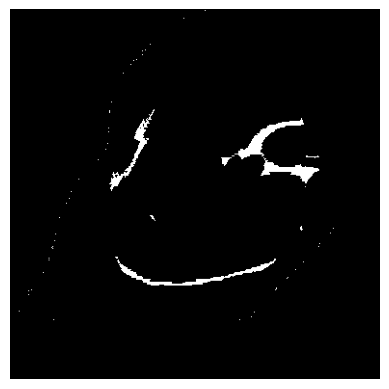

In [23]:
other_tissue_index = original_labels_bkg.index('Other_tissue')
other_tissue_mask = ex_segmentation == other_tissue_index

plt.imshow(other_tissue_mask, cmap='gray')
plt.axis('off')

N. pixels different after re-mapping: 2495


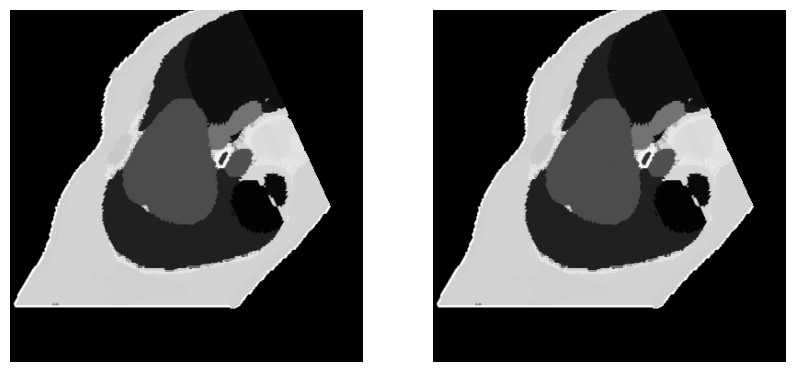

In [24]:
def find_NN(ex_segmentation, other_tissue_index, k=12):
    remap_segm = ex_segmentation.copy()

    valid_pixels = (ex_segmentation != other_tissue_index) # piexls NOT Other_tissue
    valid_coords = np.argwhere(valid_pixels)
    valid_labels = ex_segmentation[valid_coords[:,0], valid_coords[:,1]] # this is for majority voting

    target_mask = ex_segmentation == other_tissue_index
    target_indices = np.argwhere(target_mask) # Other tissue coordinates

    assert len(valid_coords) != 0, "No valid pixels found for NN search."

    if len(target_indices) == 0:
        print("No Other_tissue pixels found. No remapping needed.")
        return remap_segm
    else:
        tree = cKDTree(valid_coords)
        distances, nn_indices = tree.query(target_indices, k=k)
        neighbor_labels = valid_labels[nn_indices] # shape (num_target_pixels, k)

        if k > 1:
            majority_labels, _ = mode(neighbor_labels, axis=1)
            majority_labels = majority_labels.flatten()
        else:
            majority_labels = neighbor_labels.flatten()

        remap_segm[target_mask] = majority_labels # New label assignment

        return remap_segm
        


remapped_ex_segmentation = find_NN(ex_segmentation, other_tissue_index, k=1)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(remapped_ex_segmentation, cmap='gray',)
ax[1].imshow(remapped_ex_segmentation, cmap='gray')
for a in ax:
    a.axis('off')


print('N. pixels different after re-mapping:', np.sum(~np.equal(ex_segmentation, remapped_ex_segmentation)))

In [25]:
lut = np.zeros(len(original_labels_bkg), dtype=int)
for idx, label in enumerate(original_labels_bkg):
    if label in grouping_rules:
        group_name = grouping_rules[label]
        group_idx = new_labels.index(group_name)
        lut[idx] = group_idx # +1 IS CRUCIAL BECAUSE 0 IS THE BACKGROUND (AND WE WANT TO RE-MAP IT AS 0)
    else:
        lut[idx] = -1
        print(f'Warning: Label "{label}" not found in grouping rules. Assigned to -1.')

In [26]:
ex_seg_remapped = lut[ex_segmentation.astype(int)]
np.unique(ex_segmentation), np.unique(ex_seg_remapped)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
        65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
        78., 79., 80.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 18, 19,
        20, 21]))

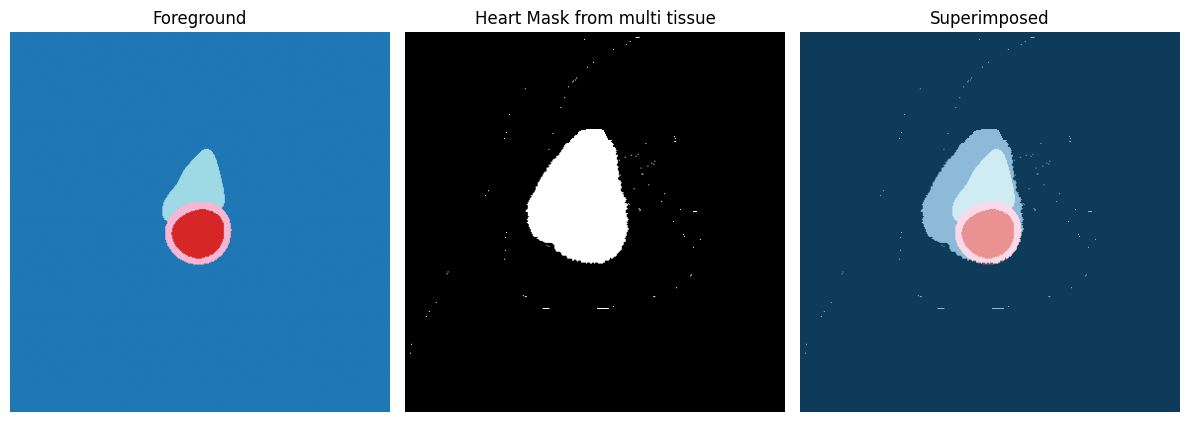

In [27]:
heart_mask = ex_seg_remapped == new_labels.index("Heart_generic")

fg = pat['mask_foreground'][:,:,7]

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(fg, cmap='tab20')
ax[0].set_title('Foreground')
ax[0].axis('off')
ax[1].imshow(heart_mask, cmap='gray')
ax[1].set_title('Heart Mask from multi tissue')
ax[1].axis('off')
ax[2].imshow(fg, cmap='tab20')
ax[2].imshow(heart_mask, cmap='gray', alpha=0.5)
ax[2].set_title('Superimposed')
ax[2].axis('off')
plt.tight_layout()

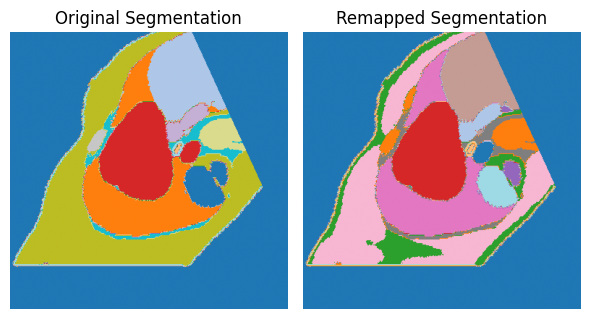

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(ex_segmentation, cmap='tab20')
ax[1].imshow(ex_seg_remapped, cmap='tab20')
ax[0].set_title('Original Segmentation')
ax[1].set_title('Remapped Segmentation')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()


#### Merge of the forground mask to the remapped segmentations

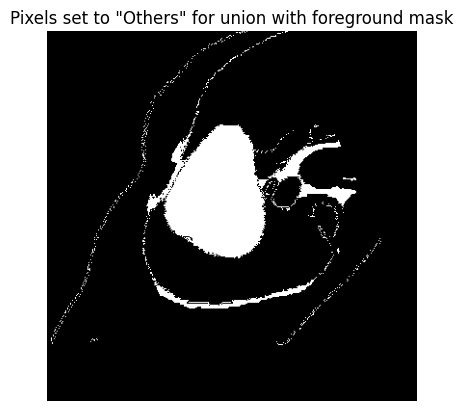

In [29]:
# Take the remapped segmentation and set to "others" all the pixels in "heart_generic"
heart_generic_idx = new_labels.index("Heart_generic")
others_idx = new_labels.index("Others") 
fg_mask = fg > 0

# Set all possible heart pixels to "Others" to account for fg mask to be bigger or smaller than the original heart segmentation ("Heart_generic")
ex_seg_remapped[ex_seg_remapped == heart_generic_idx] = others_idx
ex_seg_remapped[fg_mask] = others_idx



#### just plotting
plt.imshow(ex_seg_remapped == new_labels.index("Others"), cmap='gray')
plt.title('Pixels set to "Others" for union with foreground mask')
plt.axis('off')
plt.show()

In [30]:
## Now the foreground pixels must be remapped to match the labelling in the lut for the segmentation map (which already includes the mapping for "LV_Myocardium", "LV_blood_pool", "RV_blood_pool_myocardium")
# label 1 in fg is the LV_blood_pool, label 2 is the LV_Myocardium and label 3 is the RV_blood_pool_myocardium
fg_ready = fg.copy()
fg_ready[fg == 1] = new_labels.index("LV_blood_pool")
fg_ready[fg == 2] = new_labels.index("LV_Myocardium")
fg_ready[fg == 3] = new_labels.index("RV_blood_pool_myocardium")

np.unique(fg_ready) # mow fg_ready is ready to be merged with the remapped segmentation

pyvista_ndarray([ 0., 10., 11., 17.])

(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

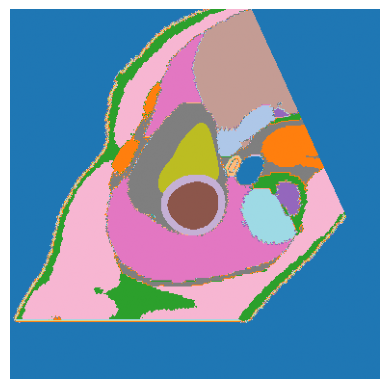

In [31]:
# just a last step to ignore 0 values in fg_ready that would be remapped to the 0 index in the new mapping

where_details = fg_ready > 0

ex_seg_remapped[where_details] = fg_ready[where_details] # that is crucial

plt.imshow(ex_seg_remapped, cmap='tab20')
plt.axis('off')

# we see there is the segmented heart and a bit of "unknown" around it, 
# which is expected since the foreground mask is not perfect and can be bigger than the original heart segmentation. 
# The rest of the segmentation is unchanged, as expected.

### Checks on fully remapped segmentations

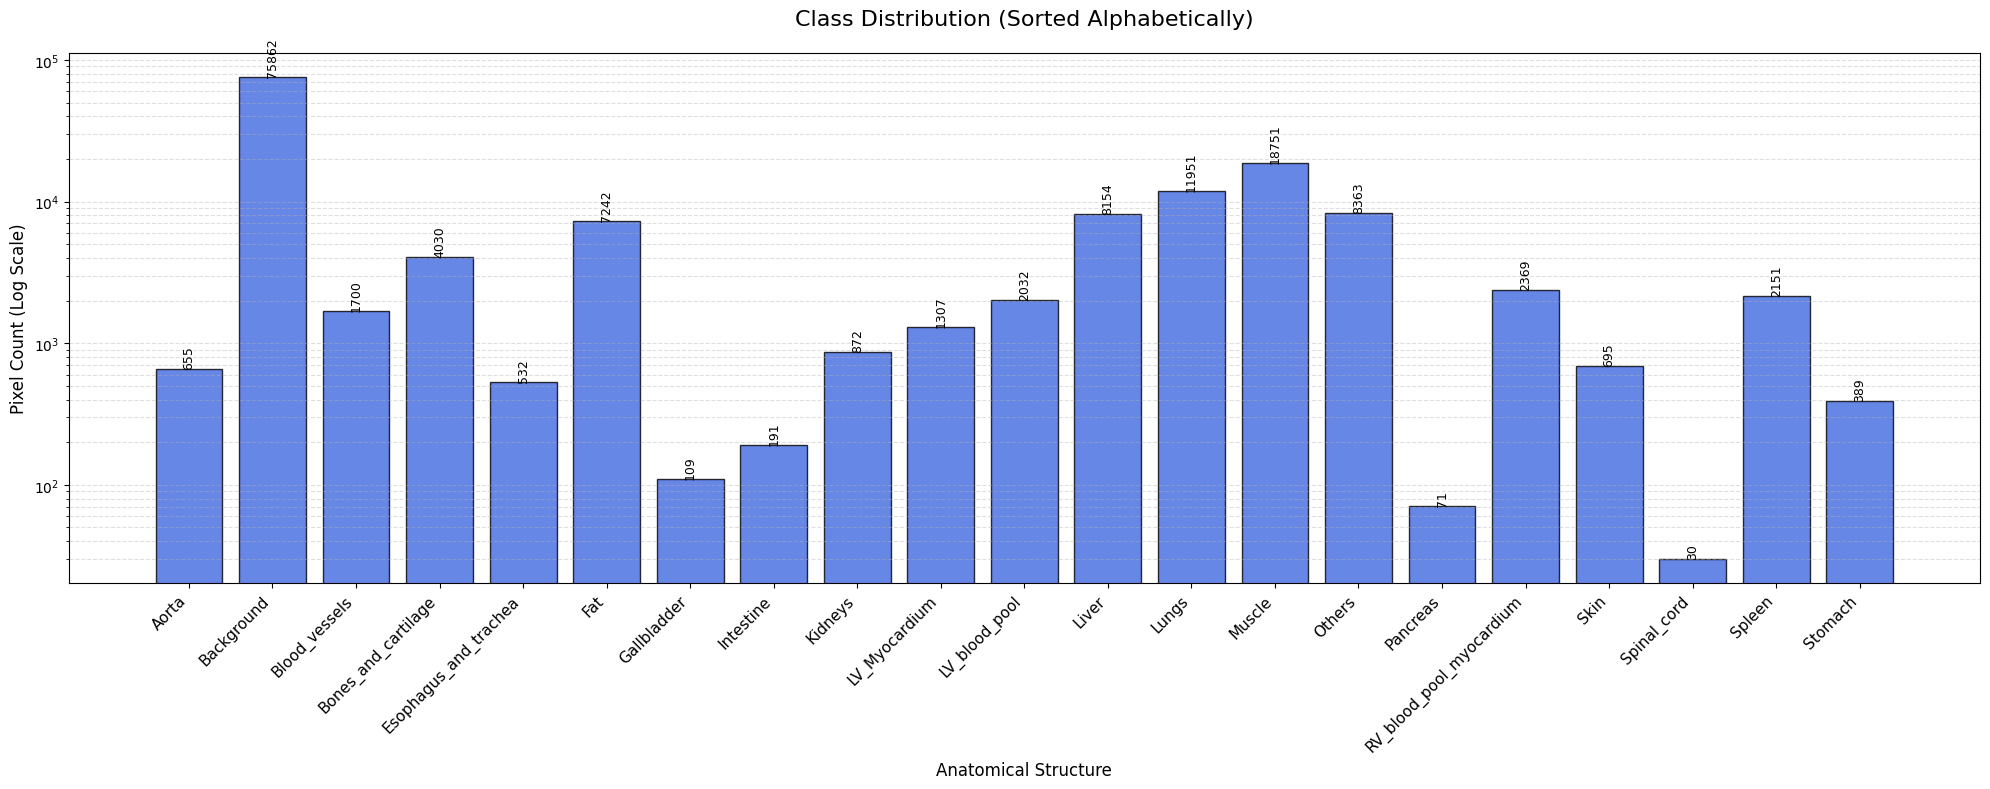

In [32]:
no_unk_labels = ["" if x == '__unused__' else x for x in new_labels]

counts = np.bincount(ex_seg_remapped.flatten().astype(int))
indices = np.arange(len(counts))

if len(no_unk_labels) < len(counts):
    diff = len(counts) - len(no_unk_labels)
    no_unk_labels.extend(["Unknown"] * diff)
elif len(no_unk_labels) > len(counts):
    no_unk_labels = no_unk_labels[:len(counts)]

mask = (counts > 0) & (np.array(no_unk_labels) != "")
filtered_labels = [no_unk_labels[i] for i in indices if mask[i]]
filtered_counts = counts[mask]

# Sort both lists alphabetically by label name
sorted_data = sorted(zip(filtered_labels, filtered_counts))
filtered_labels, filtered_counts = zip(*sorted_data)

plt.figure(figsize=(20, 8))

bars = plt.bar(range(len(filtered_labels)), filtered_counts, 
               color='royalblue', edgecolor='black', alpha=0.8)

plt.xticks(range(len(filtered_labels)), filtered_labels, 
           rotation=45, ha='right', fontsize=11)

plt.title('Class Distribution (Sorted Alphabetically)', fontsize=16, pad=20)
plt.xlabel('Anatomical Structure', fontsize=12)
plt.ylabel('Pixel Count (Log Scale)', fontsize=12)
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.4, which='both')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}', 
             va='bottom', ha='center', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()

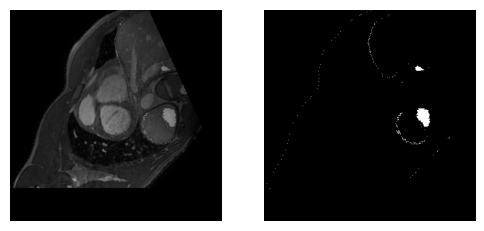

In [33]:
ex_seg_remapped_single_organ = ex_seg_remapped == new_labels.index('Kidneys')

fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(ex_slice, cmap='gray')
ax[0].imshow(ex_seg_remapped_single_organ, cmap='gray', alpha=0.3)
ax[1].imshow(ex_seg_remapped_single_organ, cmap='gray')
for a in ax:
    a.axis('off')

## Masks foreground Analysis

In [34]:
ex_foreground = pat['mask_foreground']

float64


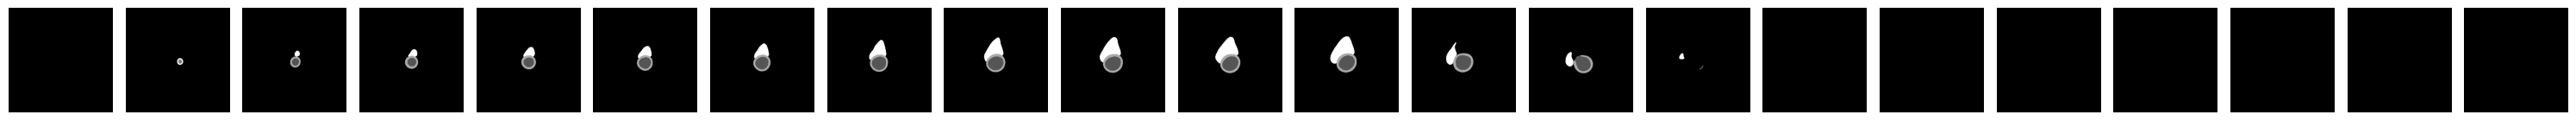

In [35]:
fig, ax = plt.subplots(1, ex_foreground.shape[2], figsize=(30, 30))
for i in range(ex_foreground.shape[2]):
    ax[i].imshow(ex_foreground[:,:,i], cmap='gray')
    ax[i].axis('off')
plt.tight_layout()

print(pat['mask_foreground'][:, :, slice_idx].dtype)

In [36]:
np.unique(pat['mask_foreground']), pat['mask_foreground'].shape

(pyvista_ndarray([0., 1., 2., 3.]), (384, 384, 22))

In [37]:
empty_slices_mask = np.all(pat['mask_foreground'] == 0, axis=(0,1))


In [38]:
len(empty_slices_mask), pat['mask_foreground'].shape, np.sum(empty_slices_mask)

(22, (384, 384, 22), np.int64(8))

## Dataset Class

In [58]:
file_list = sorted(os.listdir(DATA_PATH))

In [59]:
dataset = DatasetDIDC(DATA_PATH, grouping_rules, new_labels, target_size=(384, 384), rm_black_slices=True, file_list=file_list[:15])

Running NN filling on 171 slices...
N. pixels different after re-mapping: 842
N. pixels different after re-mapping: 709
N. pixels different after re-mapping: 822
N. pixels different after re-mapping: 844
N. pixels different after re-mapping: 1126
N. pixels different after re-mapping: 1368
N. pixels different after re-mapping: 1649
N. pixels different after re-mapping: 2320
N. pixels different after re-mapping: 2731
N. pixels different after re-mapping: 2804
N. pixels different after re-mapping: 2901
N. pixels different after re-mapping: 3909
N. pixels different after re-mapping: 4016
N. pixels different after re-mapping: 863
N. pixels different after re-mapping: 1098
N. pixels different after re-mapping: 1329
N. pixels different after re-mapping: 1393
N. pixels different after re-mapping: 1808
N. pixels different after re-mapping: 1781
N. pixels different after re-mapping: 1819
N. pixels different after re-mapping: 1837
N. pixels different after re-mapping: 1734
N. pixels different aft

In [60]:
len(dataset), dataset.fg_tensor.shape, dataset.segm_masks_tensor.shape, dataset.fg_tensor.dtype, dataset.segm_masks_tensor.dtype

(171,
 torch.Size([171, 4, 384, 384]),
 torch.Size([171, 384, 384]),
 torch.int64,
 torch.int64)

In [42]:
(dataset[147]['input_label'].shape, dataset[147]['multiClassMask'].shape,
 dataset[147]['input_label'].dtype, dataset[147]['multiClassMask'].dtype,
 np.unique(dataset[147]['input_label']), np.unique(dataset[147]['multiClassMask']))

(torch.Size([4, 384, 384]),
 torch.Size([384, 384]),
 torch.float32,
 torch.int64,
 array([0., 1.], dtype=float32),
 array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18]))

Randomly selected index: 128


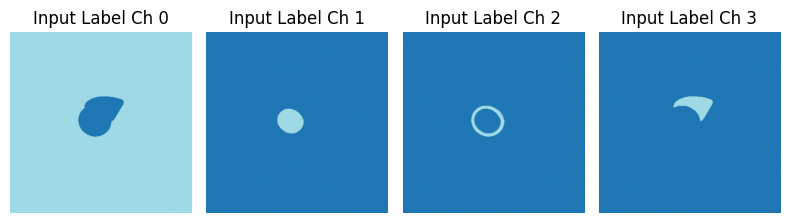

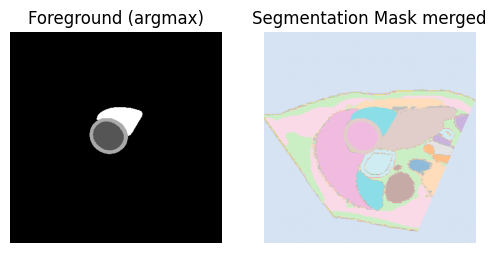

In [43]:
rnd_idx = np.random.randint(0, len(dataset))
print(f"Randomly selected index: {rnd_idx}")

fig, ax = plt.subplots(1, 4, figsize=(8, 8))
for i in range(dataset[0]['input_label'].shape[0]):
    ax[i].imshow(dataset[rnd_idx]['input_label'][i], cmap='tab20')
    ax[i].set_title(f'Input Label Ch {i}')
    ax[i].axis('off')
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(torch.argmax(dataset[rnd_idx]['input_label'], dim=0), cmap='gray')
ax[0].axis('off')
ax[0].set_title('Foreground (argmax)')

ax[1].imshow(dataset[rnd_idx]['multiClassMask'], cmap='tab20', alpha=0.5)
ax[1].axis('off')
ax[1].set_title('Segmentation Mask merged')
plt.show()

In [44]:
SEED = 187
VAL_SIZE = 0.2
all_files = sorted([f for f in os.listdir(DATA_PATH) if f.endswith('.npy')])

train_files, val_files = train_test_split(all_files, test_size=VAL_SIZE, random_state=SEED)


In [45]:
train_dataset = DatasetDIDC(DATA_PATH, grouping_rules, new_labels, target_size=(384, 384), rm_black_slices=True, file_list=train_files[:15])
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

Running NN filling on 179 slices...


In [46]:
len(train_files), len(val_files), len(train_dataset)

(389, 98, 179)

In [47]:
len(train_dataset.new_labels)

22

In [48]:
batch = next(iter(dataloader))

In [49]:
batch.keys(), batch['input_label'].shape, batch['multiClassMask'].shape, batch['input_label'].dtype, batch['multiClassMask'].dtype

(dict_keys(['input_label', 'multiClassMask']),
 torch.Size([16, 4, 384, 384]),
 torch.Size([16, 384, 384]),
 torch.float32,
 torch.int64)

## New image analysis

In [50]:
file_path = '../../DIDC-001-T01_multiclass.npy'

In [51]:
new_pat = np.load(file_path, allow_pickle=True).item()

In [52]:
new_pat['interpolated_intensity'].shape, new_pat['interpolated_segmentation'].shape, new_pat['mask_foreground'].shape

((400, 400, 311), (49760000,), (400, 400, 311))

In [53]:
new_ex_segmentation = new_pat['interpolated_segmentation'].reshape(400,400,311, order='F')

In [54]:
images_to_show = [80, 25, 50, 75, 100, 33, 54]


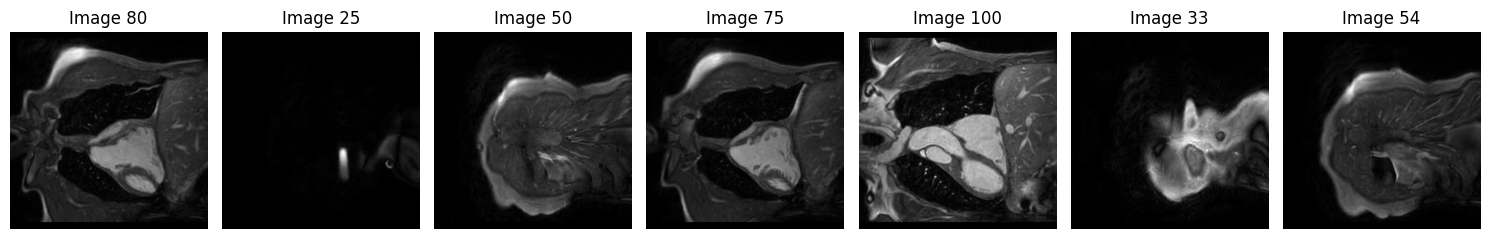

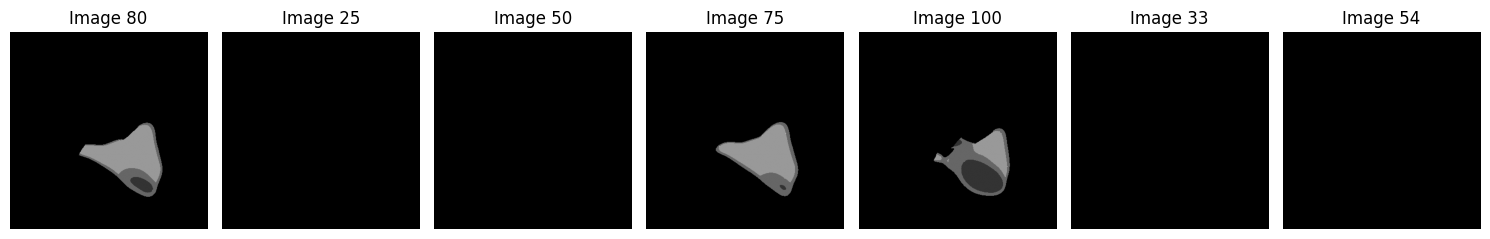

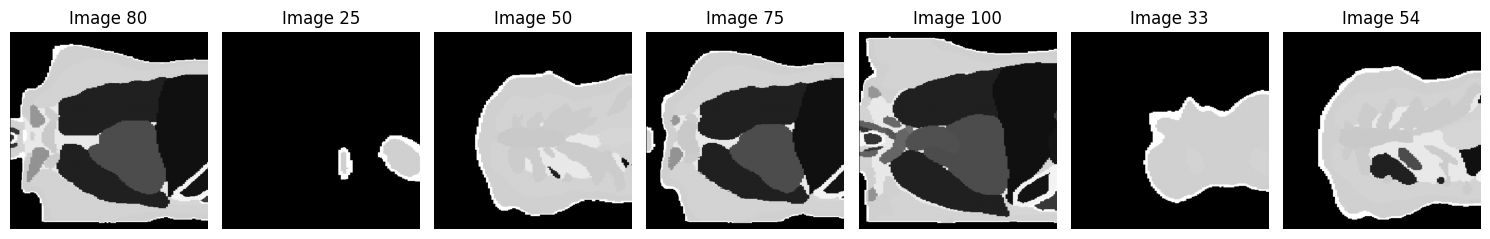

In [55]:
fig, ax = plt.subplots(1, len(images_to_show), figsize=(15, 5))
for i, idx in enumerate(images_to_show):
    ax[i].imshow(new_pat['interpolated_intensity'][:,:,idx], cmap='gray')
    ax[i].set_title(f'Image {idx}')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, len(images_to_show), figsize=(15, 5))
for i, idx in enumerate(images_to_show):
    ax[i].imshow(new_pat['mask_foreground'][:,:,idx], cmap='gray')
    ax[i].set_title(f'Image {idx}')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, len(images_to_show), figsize=(15, 5))
for i, idx in enumerate(images_to_show):
    ax[i].imshow(new_ex_segmentation[:,:,idx], cmap='gray')
    ax[i].set_title(f'Image {idx}')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

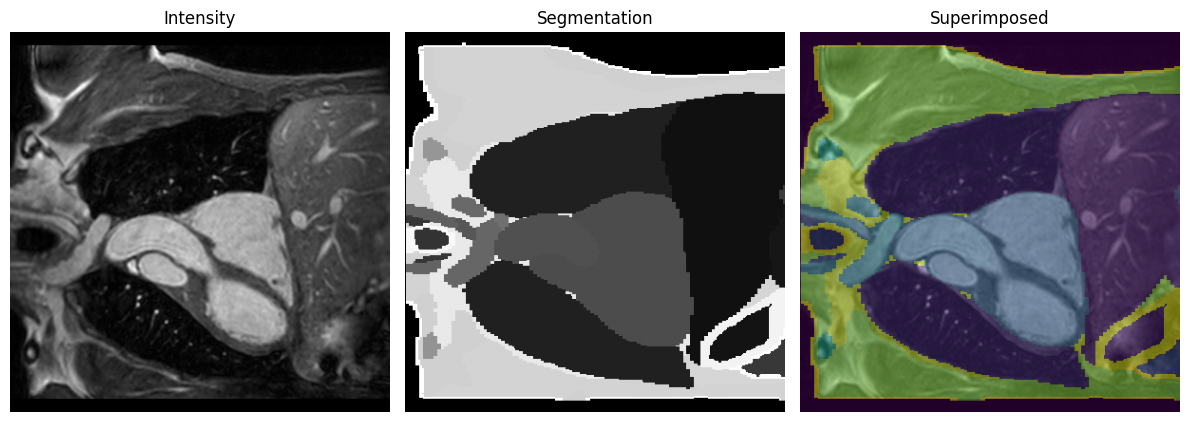

In [56]:
curr_idx = 100
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(new_pat['interpolated_intensity'][:,:,curr_idx], cmap='gray')
ax[0].set_title('Intensity')
ax[0].axis('off')
ax[1].imshow(new_ex_segmentation[:,:,curr_idx], cmap='gray')
ax[1].set_title('Segmentation')
ax[1].axis('off')
ax[2].imshow(new_pat['interpolated_intensity'][:,:,curr_idx], cmap='gray')
ax[2].imshow(new_ex_segmentation[:,:,curr_idx], cmap='viridis', alpha=0.5)
ax[2].set_title('Superimposed')
ax[2].axis('off')
plt.tight_layout()
plt.show()

In [57]:
np.unique(new_ex_segmentation[:,:,curr_idx])

array([ 0.,  5.,  6.,  7., 10., 16., 17., 18., 19., 24., 25., 27., 30.,
       31., 32., 33., 35., 46., 47., 65., 66., 67., 73., 76., 77., 78.,
       79., 80.])